<a href="https://colab.research.google.com/github/Mirlaa/Wind-Turbine/blob/main/ativa_Wind_Turbine_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import plotly.express as px
from plotly.express import box

import datetime
import time

%matplotlib inline
sns.set(rc = {"figure.figsize" : (10, 6)})
sns.set_theme(style="white")

# Dados

[Dataset original](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset).

**Dicionário**
- **Date/Time**: data em dias e horas no ano de 2018 com amostras coletadas a cada 10 minutos.
- **LV ActivePower (kW)**: Potência ativa produzida pela turbina no momento da amostra.
- **Wind Speed (m/s)**: Velocidade do vento na turbina para gerr eletricidade.
- **Theoretical_Power_Curve (KWh)**: Potencia esperada na turbina de acordo com o fabricante.
- **Wind Direction (°)**: Direção do vento na turbina.

In [2]:
uri = 'https://raw.githubusercontent.com/Mirlaa/Wind-Turbine/main/T1.csv'
data = pd.read_csv(uri)
data.head()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
data.describe()

LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589

In [5]:
data.isnull().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Pontos de limpeza e ajuste:
- A coluna de data precisa ser transforamada para datetime
- Renomear as colunas para português

## Ajustes de limpeza

In [6]:
renomear = {'Date/Time':'data',	'LV ActivePower (kW)': 'potencia_ativa',
            'Wind Speed (m/s)':'velocidade_vento',
            'Theoretical_Power_Curve (KWh)':'potencia_teorica',
            'Wind Direction (°)':'direcao_vento'}
data.rename(columns=renomear, inplace = True)
data.head()

data  potencia_ativa  velocidade_vento  potencia_teorica  \
0  01 01 2018 00:00      380.047791          5.311336        416.328908   
1  01 01 2018 00:10      453.769196          5.672167        519.917511   
2  01 01 2018 00:20      306.376587          5.216037        390.900016   
3  01 01 2018 00:30      419.645905          5.659674        516.127569   
4  01 01 2018 00:40      380.650696          5.577941        491.702972   

   direcao_vento  
0     259.994904  
1     268.641113  
2     272.564789  
3     271.258087  
4     265.674286

In [7]:
data.data = pd.to_datetime(data.data,format='%d %m %Y %H:%M')
data.head()

data  potencia_ativa  velocidade_vento  potencia_teorica  \
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908   
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511   
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016   
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569   
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972   

   direcao_vento  
0     259.994904  
1     268.641113  
2     272.564789  
3     271.258087  
4     265.674286

## Análise de dados

- Correlação;
- Direção do venod
- Scatter plots
- Catplot (talvez não, não é preciso ver a distribuição)
- windrose plot

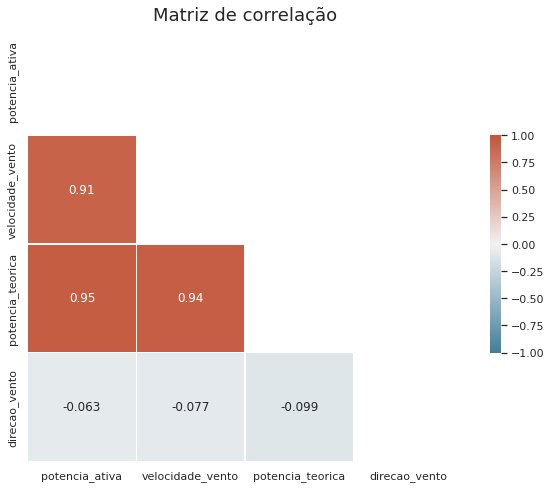

In [8]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax = 1, center=0,
            annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matriz de correlação', fontsize = 18)
plt.show()

Talvez vá valer a pena remover a coluna `Direcao_Vento` devido a baixa correlação negativa à variável target

In [9]:
! pip install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


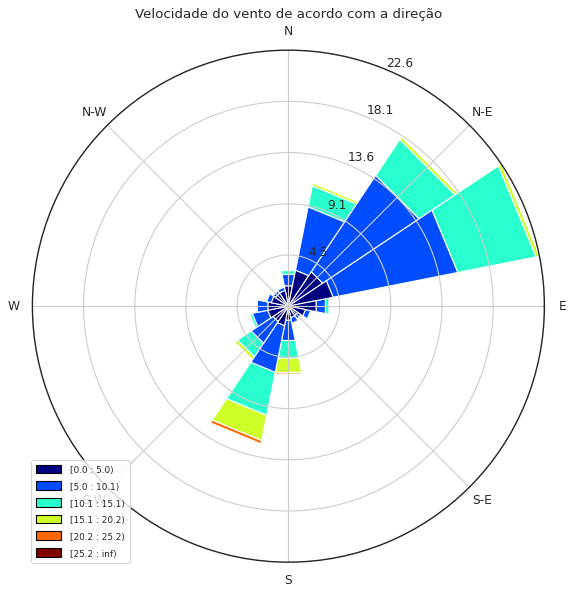

In [10]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(data['direcao_vento'], data['velocidade_vento'], normed=True, opening=1, edgecolor='white')
ax.set_legend()
plt.title("Velocidade do vento de acordo com a direção")
plt.show()

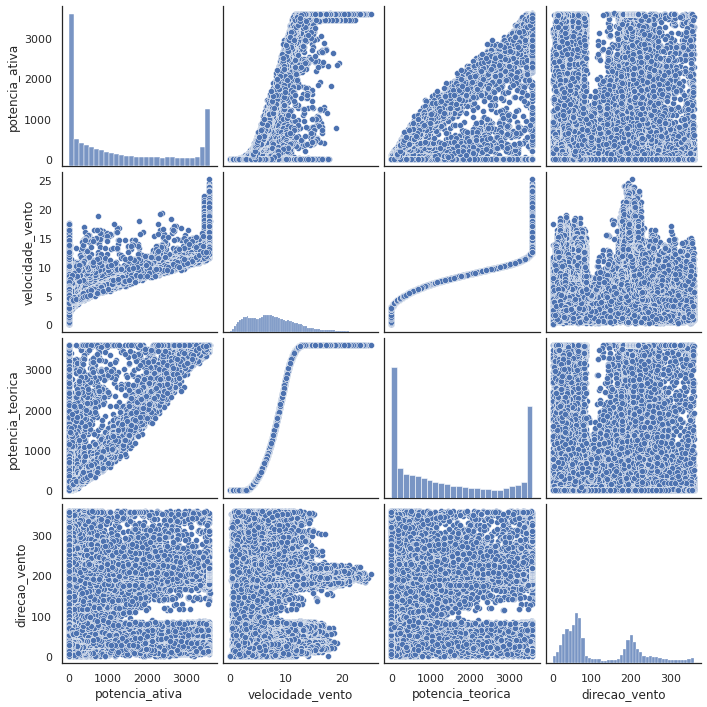

In [11]:
sns.pairplot(data)
plt.show()

Aparentemente a direção do vento não tem muita influencia no resultado final.

Vamos entender o comportamento da potencia gerada e a velocidade do vento.

In [12]:
limites_velocidade = [4.201395, 7.104594, 10.300020]
categorias_velocidade = []
for i in data['velocidade_vento']:
  if i <= limites_velocidade[0]:
    categorias_velocidade.append('A')
  elif i <= limites_velocidade[1]:
    categorias_velocidade.append('B')
  elif i <= limites_velocidade[2]:
    categorias_velocidade.append('C')
  else:
    categorias_velocidade.append('D')

data_categorias = data.copy()
data_categorias['categoria_velocidade'] = categorias_velocidade
data_categorias.head()

data  potencia_ativa  velocidade_vento  potencia_teorica  \
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908   
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511   
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016   
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569   
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972   

   direcao_vento categoria_velocidade  
0     259.994904                    B  
1     268.641113                    B  
2     272.564789                    B  
3     271.258087                    B  
4     265.674286                    B

- A = (m/s) <= 4.201395
- B = 4.201395 < (m/s) <= 7.104594
- C = 7.104594 < (m/s) <= 10.300020
- D = 10.300020 < (m/s)

In [13]:
limites_direcao = [49.315437, 73.712978, 201.696720]
categorias_direcao = []
for i in data['direcao_vento']:
  if i < limites_direcao[0]:
    categorias_direcao.append('A')
  elif i < limites_direcao[1]:
    categorias_direcao.append('B')
  elif i < limites_direcao[2]:
    categorias_direcao.append('C')
  else:
    categorias_direcao.append('D')
data_categorias['categoria_direcao'] = categorias_direcao
data_categorias.head()

data  potencia_ativa  velocidade_vento  potencia_teorica  \
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908   
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511   
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016   
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569   
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972   

   direcao_vento categoria_velocidade categoria_direcao  
0     259.994904                    B                 D  
1     268.641113                    B                 D  
2     272.564789                    B                 D  
3     271.258087                    B                 D  
4     265.674286                    B                 D

- A = (m/s) <= 49.315437
- B = 49.315437 < (m/s) <= 73.712978
- C = 73.712978 < (m/s) <= 201.696720
- D = 201.696720 < (m/s)

In [14]:
fig = px.scatter(data_categorias,  x='velocidade_vento', y='potencia_ativa',
                 color='categoria_velocidade',title='Titulo',
                 hover_data=['velocidade_vento','potencia_ativa'])

fig.show()

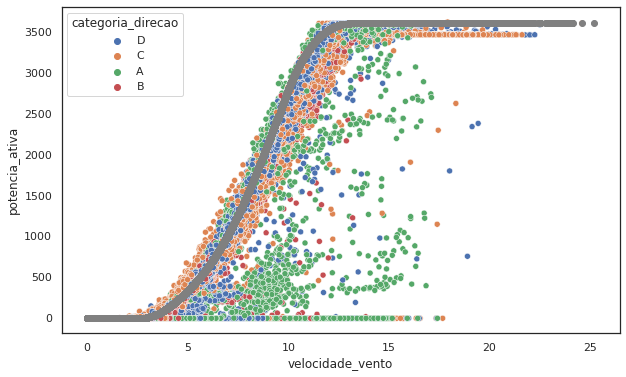

In [15]:
sns.scatterplot(data=data_categorias, x='velocidade_vento', y='potencia_ativa', hue='categoria_direcao')
plt.scatter(data_categorias['velocidade_vento'],data_categorias['potencia_teorica'], color='gray')
plt.show()

In [16]:
import plotly.graph_objects as go

fig = px.scatter(data_categorias,  x='velocidade_vento', y='potencia_ativa',
                 color='categoria_direcao',title='Velocidade pelo vento - direçao',
                 hover_data=['categoria_direcao'])
fig.show()

In [17]:
#correlação
corr = data.corr()
corr

potencia_ativa  velocidade_vento  potencia_teorica  \
potencia_ativa          1.000000          0.912774          0.949918   
velocidade_vento        0.912774          1.000000          0.944209   
potencia_teorica        0.949918          0.944209          1.000000   
direcao_vento          -0.062702         -0.077188         -0.099076   

                  direcao_vento  
potencia_ativa        -0.062702  
velocidade_vento      -0.077188  
potencia_teorica      -0.099076  
direcao_vento          1.000000

Agora, iremos trabalhar com as datas, verificando o quanto o horário e o mês influenciam na velocidade do vento.

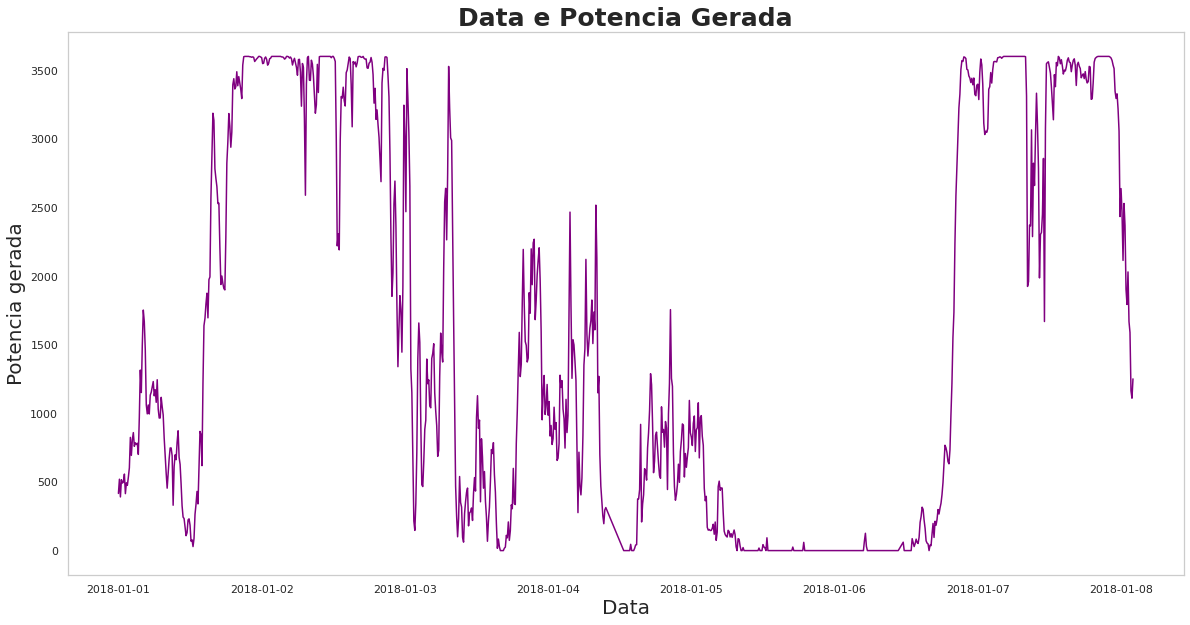

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data['data'][0:1000],
        data['potencia_teorica'][0:1000],
        color='purple')
ax.set_title('Data e Potencia Gerada',fontweight="bold", size=25)
ax.set_ylabel('Potencia gerada', fontsize = 20)
ax.set_xlabel('Data', fontsize = 20)
plt.grid(False)
plt.show()

Assim sendo, é notório que para esse conjunto de dados, a direção do vento, o e a data pouco nos tras informação sobre o produro final.

In [19]:
colunas = ['direcao_vento']
data = data.drop(colunas, axis=1)
data.head()

data  potencia_ativa  velocidade_vento  potencia_teorica
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972

In [20]:
dados = data.copy()
dados.head()

data  potencia_ativa  velocidade_vento  potencia_teorica
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972

## Tratamento

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [22]:
df = dados.copy()
df.head()

data  potencia_ativa  velocidade_vento  potencia_teorica
0 2018-01-01 00:00:00      380.047791          5.311336        416.328908
1 2018-01-01 00:10:00      453.769196          5.672167        519.917511
2 2018-01-01 00:20:00      306.376587          5.216037        390.900016
3 2018-01-01 00:30:00      419.645905          5.659674        516.127569
4 2018-01-01 00:40:00      380.650696          5.577941        491.702972

Vamos remover os valores que não estão na produção

In [23]:
df = df.drop(['potencia_teorica','velocidade_vento'], axis=1)

In [24]:
df = df.set_index('data') # os valores de data serão nossas referencias
df

potencia_ativa
data                               
2018-01-01 00:00:00      380.047791
2018-01-01 00:10:00      453.769196
2018-01-01 00:20:00      306.376587
2018-01-01 00:30:00      419.645905
2018-01-01 00:40:00      380.650696
...                             ...
2018-12-31 23:10:00     2963.980957
2018-12-31 23:20:00     1684.353027
2018-12-31 23:30:00     2201.106934
2018-12-31 23:40:00     2515.694092
2018-12-31 23:50:00     2820.466064

[50530 rows x 1 columns]

In [25]:
df = df[:-10]
df.tail()

potencia_ativa
data                               
2018-12-31 21:30:00     1814.355957
2018-12-31 21:40:00     1992.348999
2018-12-31 21:50:00     2554.377930
2018-12-31 22:00:00     2681.270020
2018-12-31 22:10:00     3019.893066

Preparamos os dados agora para serem enviados à previsão.

Para tal, iniciamos transformando os valores para dados estacionários.

In [26]:
valores = df.values
diferenca = 1
diff = []
for i in range(1, len(valores)):
    val = valores[i] - valores[i - diferenca]
    diff.append(val)
diff[:6]

[array([73.72140503]),
 array([-147.39260864]),
 array([113.26931763]),
 array([-38.99520874]),
 array([21.74130249]),
 array([45.2137146])]

In [27]:
diff = pd.Series(diff)

In [28]:
diff

0         [73.72140502929699]
1         [-147.392608642578]
2        [113.26931762695301]
3        [-38.99520874023398]
4        [21.741302490233977]
                 ...         
50514      [-426.27392578125]
50515       [177.99304199218]
50516       [562.02893066407]
50517       [126.89208984375]
50518         [338.623046875]
Length: 50519, dtype: object

Com a diferrenciação, podemos agora criar dimensões de previsão com os valores esperados.

A quantidade de dimensões é variada a depender do desempenho do modelo.

In [73]:
df_dif

0
0       [73.72140502929699]
1       [-147.392608642578]
2      [113.26931762695301]
3      [-38.99520874023398]
4      [21.741302490233977]
...                     ...
50514    [-426.27392578125]
50515     [177.99304199218]
50516     [562.02893066407]
50517     [126.89208984375]
50518       [338.623046875]

[50519 rows x 1 columns]

In [71]:
df_dif = pd.DataFrame(diff)

<Figure size 1440x1440 with 0 Axes>

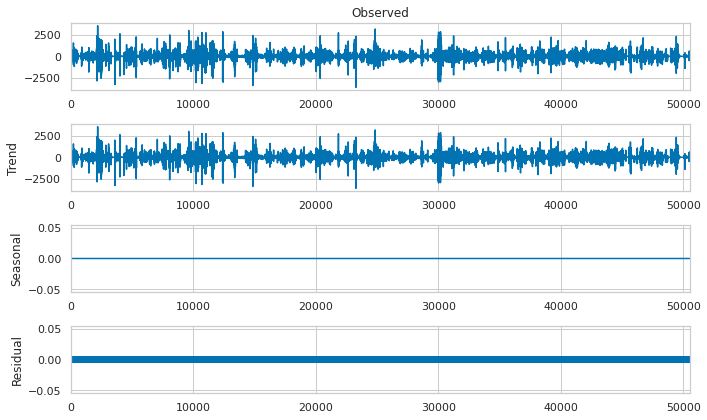

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_dif.values,period = 1)
plt.figure(figsize=(20,20))
decomp.plot()
plt.show()

In [30]:
dim = 24
col = [df_dif.shift(i) for i in range(1, dim+1)]
col.append(df_dif)
col[:3]

[                          0
 0                       NaN
 1       [73.72140502929699]
 2       [-147.392608642578]
 3      [113.26931762695301]
 4      [-38.99520874023398]
 ...                     ...
 50514     [339.02783203125]
 50515    [-426.27392578125]
 50516     [177.99304199218]
 50517     [562.02893066407]
 50518     [126.89208984375]
 
 [50519 rows x 1 columns],                           0
 0                       NaN
 1                       NaN
 2       [73.72140502929699]
 3       [-147.392608642578]
 4      [113.26931762695301]
 ...                     ...
 50514    [-408.27294921875]
 50515     [339.02783203125]
 50516    [-426.27392578125]
 50517     [177.99304199218]
 50518     [562.02893066407]
 
 [50519 rows x 1 columns],                          0
 0                      NaN
 1                      NaN
 2                      NaN
 3      [73.72140502929699]
 4      [-147.392608642578]
 ...                    ...
 50514    [247.32592773438]
 50515   [-408.272949218

In [31]:
df_dif = pd.concat(col, axis=1)
df_dif.fillna(0, inplace=True)
df_dif.head()

0                     0                    0  \
0                     0                     0                    0   
1   [73.72140502929699]                     0                    0   
2   [-147.392608642578]   [73.72140502929699]                    0   
3  [113.26931762695301]   [-147.392608642578]  [73.72140502929699]   
4  [-38.99520874023398]  [113.26931762695301]  [-147.392608642578]   

                     0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  \
0                    0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
1                    0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
2                    0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
3                    0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   
4  [73.72140502929699]  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0   

                      0  
0   [73.72140502929699]  
1   [-147.392608642578]  
2  [113.26931762695301]  
3  [-38.99520874023398]  
4  [21.741302490233977]  

[5 rows x 25 columns]

In [32]:
df_dif.shape

(50519, 25)

In [33]:
val_dim = df_dif.values
val_dim[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, array([73.72140503])],
       [array([73.72140503]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, array([-147.39260864])],
       [array([-147.39260864]), array([73.72140503]), 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        array([113.26931763])],
       [array([113.26931763]), array([-147.39260864]),
        array([73.72140503]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, array([-38.99520874])],
       [array([-38.99520874]), array([113.26931763]),
        array([-147.39260864]), array([73.72140503]), 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, array([21.74130249])]],
      dtype=object)

Podemos dividir nossos dados em conjuntos de treino e teste, definindo 1000 valores de dados para teste e o restante do conjunto, para treino (49519 amostras).

In [34]:
treino,teste = val_dim[0:-1000],val_dim[-1000:]

Por fim, pra evitar enviesamento e outros problemas de treinamento, iremos normalizar o dados entre valores `-1` e `1`.

In [89]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(treino)
treino_norm = scaler.transform(treino)
teste_norm = scaler.transform(teste)

In [85]:
treino_norm.shape

(49519, 25)

# Treino

Definiremos entradas e saidas

In [36]:
x_treino, y_treino = treino_norm[:, 0:-1], treino_norm[:, -1]
x_treino.shape[1]

24

In [37]:
x_treino = x_treino.reshape(x_treino.shape[0], 1, x_treino.shape[1])
x_treino.shape

(49519, 1, 24)

In [38]:
model = keras.Sequential([
                              keras.layers.LSTM(10,stateful=True,batch_input_shape=(1, x_treino.shape[1], x_treino.shape[2])),
                              keras.layers.Dense(1)
                              ])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
for i in range(15):
      model.fit(x_treino, y_treino, epochs=1, batch_size=1, verbose=1, shuffle=False)
      model.reset_states()

49519/49519 [==============================] - 100s 2ms/step - loss: 0.0045


# Teste

In [91]:
predicoes, esperado, plot_pred, plot_esp = list(), list(), list(), list()
y_pred_teste = list()

for i in range(len(teste_norm)):
  x, y = teste_norm[i,0:-1], teste_norm[i,-1]

  ## Predição
  y_pred = model.predict(x.reshape(1,1,len(x)), batch_size=1)
  y_pred = y_pred[0,0]
  
  # invertendo a escala
  inv_escala = np.array([j for j in x] + [y_pred])
  inv_escala = inv_escala.reshape(1, len(inv_escala))
  y_pred_modelo = scaler.inverse_transform(inv_escala)
  y_pred_modelo = y_pred_modelo[0,-1]
  
  ## inverte a diferenciação
  y_pred_modelo = y_pred_modelo + valores[-(len(teste_norm)+1-i)]

  ## historico
  plot_pred.append(y_pred_modelo)
  plot_esp.append(valores[len(treino) + i + 1])
  if valores[len(treino) + i + 1] != 0:
    predicoes.append(y_pred_modelo)
    esperado.append(valores[len(treino) + i + 1])
  # print(f'Predição = {y_pred_modelo}, Esperado = {valores[len(treino) + i + 1]}')

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
esperado = np.array(esperado)
predicoes = np.array(predicoes)
print("MSE:", mean_squared_error(esperado, predicoes))
print("Mean Absolute Percent Error: ", (np.mean(np.abs((esperado - predicoes) / esperado))))

MSE: 54306.14261703875
Mean Absolute Percent Error:  0.5966235277963574


In [96]:
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def computeTheilU2(y_true, y_pred):
    N = len(y_true)
    
    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)
    
    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))
        
    theilU2 = numerator / denominator
    
    return theilU2
computeTheilU2(esperado, predicoes)

0.8565856820244233

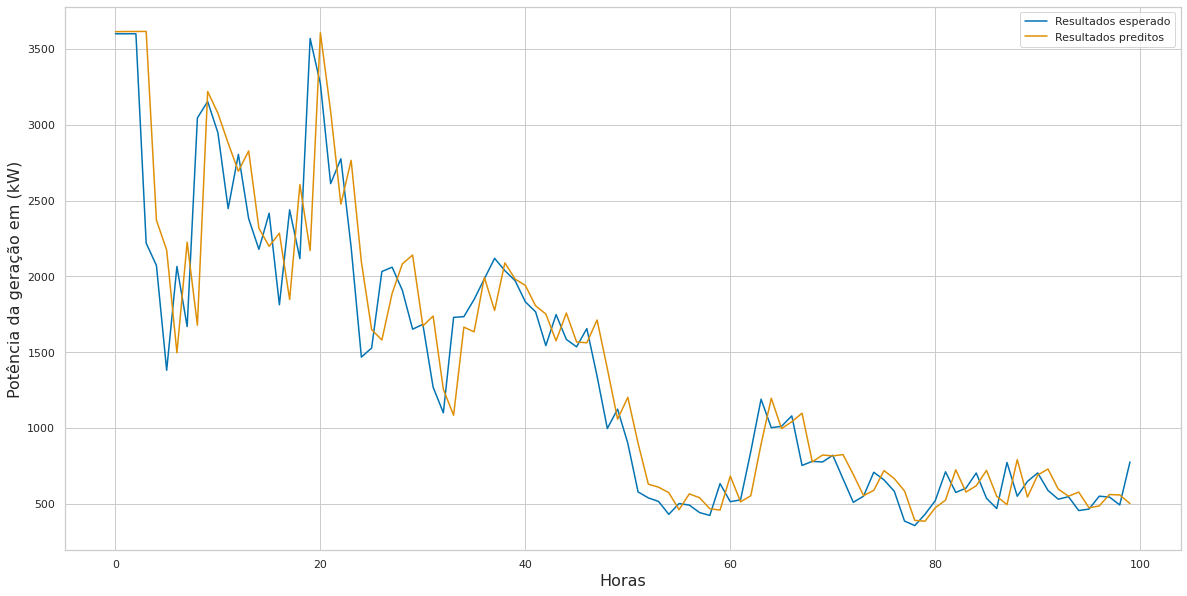

In [95]:
sns.set_style("whitegrid")
sns.set_theme(style="whitegrid", palette='colorblind')
plt.figure(figsize=(20,10))
plt.plot(plot_esp[0:100], label="Resultados esperado")
plt.plot(plot_pred[0:100], label="Resultados preditos")
plt.legend(loc='upper right')
plt.xlabel("Horas",fontsize=16)
plt.ylabel("Potência da geração em (kW)",fontsize=16)
plt.show()